# Ch07 Combining Different Models for Ensemble Learning

**학습 내용**
- 다수결 (majority voting)에 기인한 예측
- training set의 반복추출 무작위 조합을 통한 과적합 방지
- weak learner로부터 powerful한 모델 설립

## 1) Learning with ensembles

**앙상블 기법** : 서로 다른 분류기(classifier)를 결합한 meta-classifier를 통해 단일 분류기보다 더 좋고 일반화된 성능을 구현하는 방법

ex ) 10명의 전문가 의견 종합 vs  1명의 전문가 의견

**Voting**
- majority voting (다수결) : 각 분류기를 통해 예측된 class label 중 다수인 것을 선택 (binary classification)
- plurality voting (최다득표) : multi-class setting
- unanimity (만장일치)

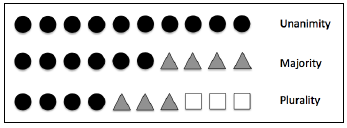

In [1]:
from IPython.display import Image
Image("./fig/voting.png")

**Procedure**
- 1개의 training set을 m개의 서로 다른 분류기로 분류
- training set의 서로 다른 subset을 단일 분류기로 분류 (Random Forest)

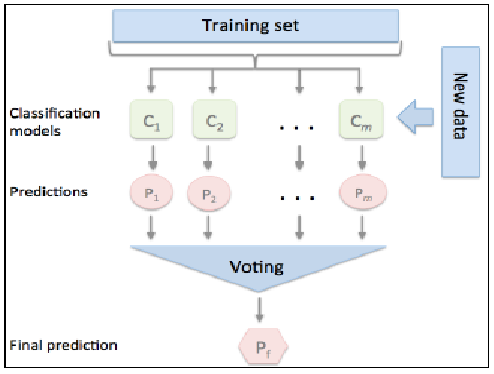

In [2]:
Image("./fig/ensemble_pipeline.png")

**왜 앙상블 기법이 단일 분류기보다 성능이 좋은가?**

In [4]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [5]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

**base error가 0.5 이하인 분류기에 ensemble기법을 적용해야 좋은 성능을 나타냄**

In [6]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

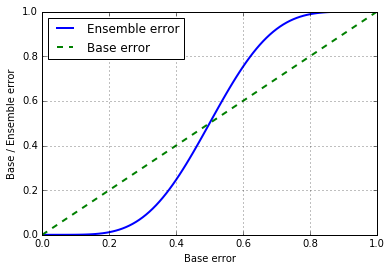

In [7]:
import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base / Ensemble error')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

## 2) Implementing a simple majority vote classifier

### a) Combining different algorithms for classification with majority vote

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
iris

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==

In [10]:
X, y = iris.data[50:, [1, 2]], iris.target[50:] # feture는 sepal lengt와 sepal width 선택, target은 versicolor와 virginica 선택

In [11]:
le = LabelEncoder() # sepal length와 sepal width를 각각 0과 1로 인코딩
y = le.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1) # train, test set 나누기

In [13]:
# 10 fold cross validation 적용
# 3가지 분류기 결합 : Logistic regression, Decision tree, KNN
# Pipeline 설정

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty = 'l2', C = 0.001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

In [20]:
clf_labels = ["Logistic Regression", "Decision Tree", "KNN"]
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                            X = X_train,
                            y = y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [19]:
# Majority voting을 이용한 classification

from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier(estimators = [('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting = 'soft') 
clf_labels += ['Majority Voting']

for clf, label in zip([pipe1, clf2, pipe3, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X = X_train,
                            y = y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


## 3) Evaluating and tuning the ensemble classifier

[ 0.          0.          0.          0.          0.          0.
  0.13636364  0.13636364  0.18181818  0.18181818  0.22727273  0.31818182
  0.31818182  0.5         0.5         0.63636364  0.63636364  1.        ]
[ 0.          0.18181818  1.        ]
[ 0.          0.13636364  1.        ]
[ 0.          0.          0.          0.          0.          0.
  0.04545455  0.09090909  0.09090909  0.22727273  0.22727273  0.63636364
  0.63636364  1.        ]


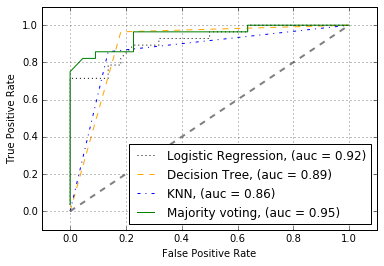

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyle = [':', '--', '-.', '-']
all_clf = [pipe1, clf2, pipe3, mv_clf]
clf_labels = ["Logistic Regression", "Decision Tree", "KNN", "Majority voting"]


for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
    
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[: , 1]
    #print(clf.fit(X_train, y_train).predict_proba(X_test))
    #print(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    
    plt.plot(fpr, tpr, color = clr, linestyle = ls, 
            label = '%s, (auc = %0.2f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color='gray', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [26]:
X_test.shape

(50, 2)

In [28]:
# parameter tunning 하기 전 tunning 파라미터 목록 확인
mv_clf.get_params()

{'dt': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_split': 1e-07,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': False,
 'dt__random_state': 0,
 'dt__splitter': 'best',
 'estimators': [('lr',
   Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=0, solver='liblinear', tol=0.0001

In [35]:
# Gridsearch CV를 통한 최적의 parameter 찾기

from sklearn.grid_search import GridSearchCV
params = {'dt__max_depth' : [1, 2, 3, 4],
          'lr__clf__C' : [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator = mv_clf,
                    param_grid = params,
                    cv = 10,
                    scoring = 'roc_auc')

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=VotingClassifier(estimators=[('lr', Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0...ki',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]]))],
         n_jobs=1, voting='soft', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lr__clf__C': [0.001, 0.1, 100.0], 'dt__max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [36]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))

0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 1}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 1}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 1}
0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 2}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 2}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 2}
0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 3}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 3}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 3}
0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 4}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 4}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 4}


In [37]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'lr__clf__C': 100.0, 'dt__max_depth': 1}


In [38]:
print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


## 4) Bagging – building an ensemble of classi ers from bootstrap samples

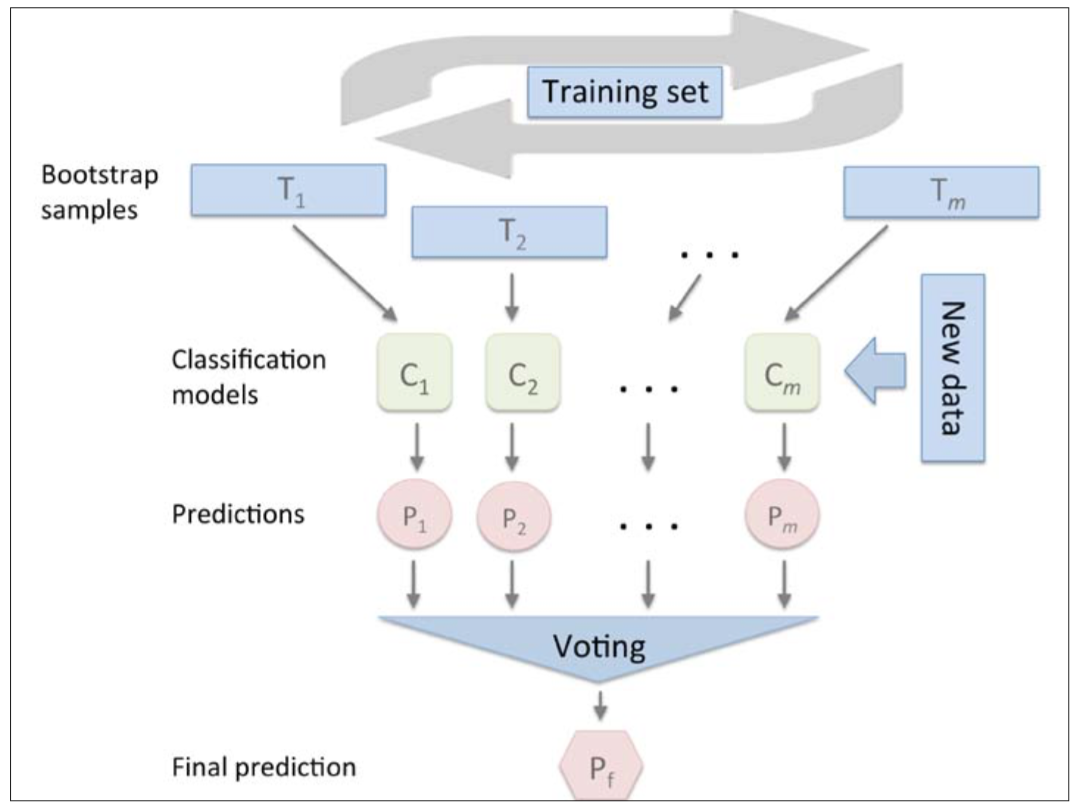

In [39]:
from IPython.display import Image
Image("./fig/bagging.png")

- training set을 bootstrap sampling(반복 무작위 추출) 수행 -> 여러개의 데이터 생성 (bootstrap aggregating)
- 랜덤 포레스트 : bagging방법 중 하나

**Bagging을 적용하면 안되는 경우**
- 표본 데이터가 작은 경우
- 데이터에 noise가 많은 경우 (Outlier 등)
- feature간 의존성이 있는 경우

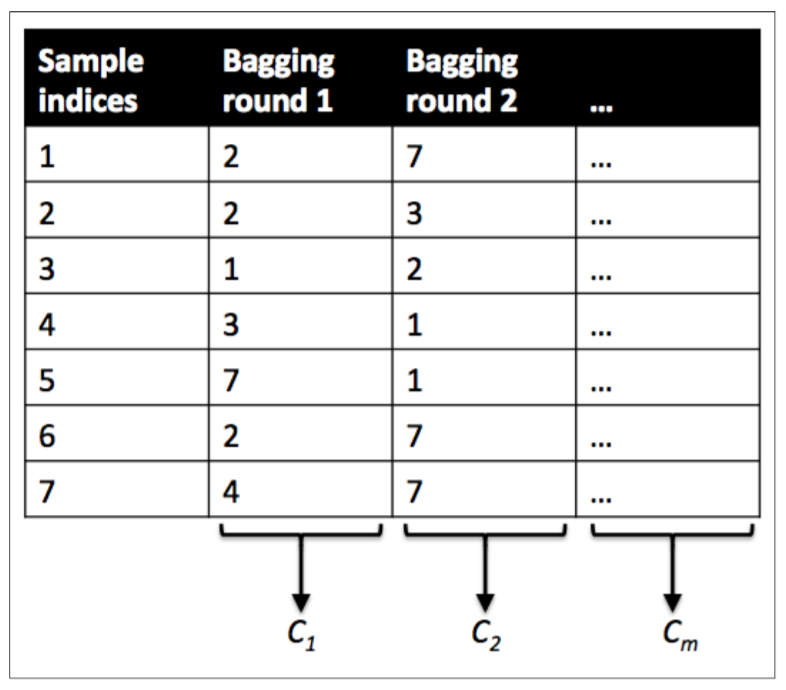

In [40]:
Image("./fig/bagging_ex.png")

In [1]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [44]:
df_wine

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.640000,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.750000,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.250000,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.050000,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.200000,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.220000,1.01,3.55,1045


In [2]:
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]

In [3]:
df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.950000,1.050,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.270000,1.250,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.750000,0.980,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.800000,1.230,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.450000,1.220,2.87,420
64,2,12.17,1.45,2.53,19.0,104,1.89,1.75,0.45,1.03,2.950000,1.450,2.23,355
65,2,12.37,1.21,2.56,18.1,98,2.42,2.65,0.37,2.08,4.600000,1.190,2.30,678
66,2,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.300000,1.120,3.18,502
67,2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.680000,1.120,3.48,510
68,2,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.170000,1.020,1.93,750


In [4]:
# Alcohol과 Hue라는 feature를 이용해 classification
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [5]:
# Label encoding, data split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.4,
                                                   random_state = 1)

In [7]:
# Bagging classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth = None)

bag = BaggingClassifier(base_estimator = tree,
                       n_estimators = 500,
                       max_samples = 1.0,
                       max_features = 1.0,
                       bootstrap = True,
                       bootstrap_features = False,
                       n_jobs = 1,
                       random_state = 1)

In [9]:
X_train.shape[1]

2

**single unpruned decision tree 성능 (overfitting)**

In [10]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print("Decision tree train/test accuracies %.3f/%3f" %(tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833333


**bagging classifier 성능 (more generalization)**

In [11]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print("Bagging train/test accuracies %.3f/%3f" %(bag_train, bag_test))

Bagging train/test accuracies 1.000/0.895833


**시각화 (DT vs Bagging)**

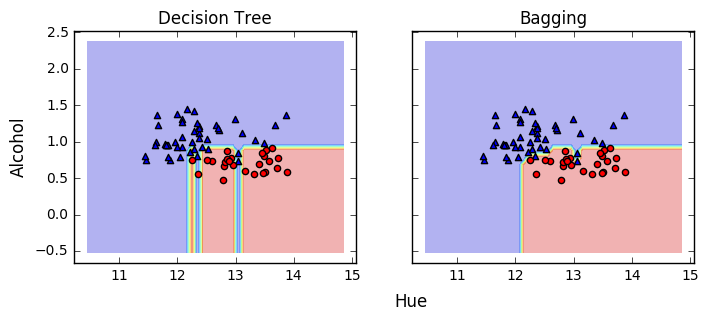

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_train[:, 0].min() -1, X_train[: , 0].max() + 1
y_min, y_max = X_train[:, 1].min() -1, X_train[: , 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt in zip([0, 1], 
                        [tree, bag], 
                        ['Decision Tree', 'Bagging']):
    
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'red', marker = 'o')
    axarr[idx].set_title(tt)

    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s= 'Hue',
         ha='center', va='center', fontsize=12)
plt.show()
    

## 4. Leveraging weak learners via adaptive boosting (AdaBoost)

**Boosting** : weak learner로부터 strong learner를 만드는 것으로 weak learner에 가중치(weight)를 두는 방식으로 모델링

**weak learner** : 아주 simple한 classifier, 누가봐도 제대로 작동하지 않을것 같은 모델
- 어른과 어린이를 구분할 때 키가 160 이상이면 어른 이하면 아이.
- 남자와 여자를 구분할 때, 머리카락 길이가 20센치 이상이면 여자 이하면 남자.
- 좋은 컴퓨터와 나쁜 컴퓨터를 구분할 때, 크기가 크면 나쁜 컴퓨터 작으면 좋은 컴퓨터


**Key step**

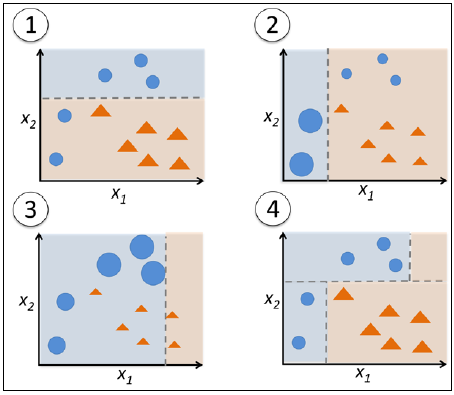

In [28]:
from IPython.display import Image
Image("./fig/adaboost.png")

**AdaBoost 과정 예제**

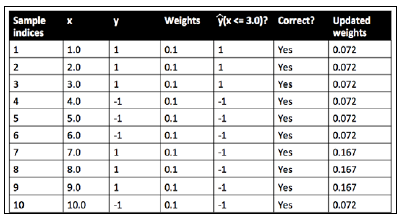

In [29]:
Image("./fig/adaboost_ex.png")

In [24]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth = 1)

ada = AdaBoostClassifier(base_estimator = tree,
                        n_estimators = 500,
                         learning_rate = 0.1,
                         random_state = 0)

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print("Decision tree train/test accuracies %.3f/%3f" %(tree_train, tree_test))

Decision tree train/test accuracies 0.845/0.854167


In [26]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print("AdaBoost train/test accuracies %.3f/%3f" %(ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.875000


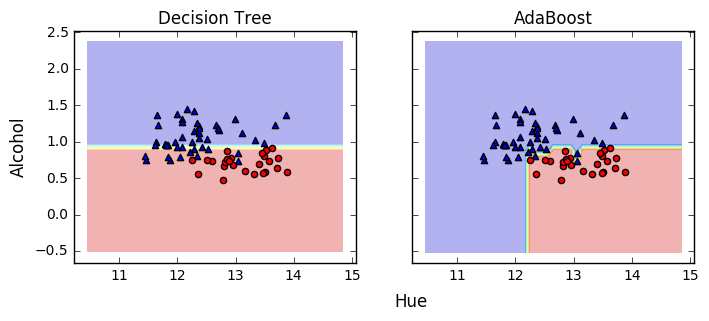

In [27]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_train[:, 0].min() -1, X_train[: , 0].max() + 1
y_min, y_max = X_train[:, 1].min() -1, X_train[: , 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt in zip([0, 1], 
                        [tree, ada], 
                        ['Decision Tree', 'AdaBoost']):
    
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'red', marker = 'o')
    axarr[idx].set_title(tt)

    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s= 'Hue',
         ha='center', va='center', fontsize=12)
plt.show()